# How SequenceToSequence works

<h1>Table of Contents<span class="tocSkip"></span></h1>

<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3">Data preparation</a></span></li>
<li><span><a href="#SequenceToSequence model" data-toc-modified-id="SequenceToSequence-model-4">SequnceToSequence model</a></span></li>
<ul class="toc-item">
<li><span><a href="#Model-instantiation" data-toc-modified-id="Model-instantiation-4.1">Model instantiation</a></span>
<li><span><a href="#How-to-choose-an-appropriate-backbone-for-your-dataset?" data-toc-modified-id="How-to-choose-an-appropriate-backbone-for-your-dataset?-4.2">How to choose an appropriate backbone for your dataset?</a></span>    
<li><span><a href="#Model-training" data-toc-modified-id="Model-training-4.3">Model training</a></span>
    <ul class="toc-item">
        <li><span><a href="#Finding-optimum-learning-rate" data-toc-modified-id="Finding-optimum-learning-rate-4.3.1">Finding optimum learning rate</a></span>
        <li><span><a href="#Evaluate-model-performance" data-toc-modified-id="Evaluate-model-performance-4.3.2">Evaluate model performance</a></span>
        <li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-4.3.3">Validate results</a></span></li> 
    </ul>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-5">Model inference</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-6">References</a></span></li>
</ul>
</div>

# Introduction

`SequenceToSequence` model can be used for multiple tasks that fall under the category of sequence translation. 
Sequence translation is the task of translating an input sequence to an output sequence of any length (independent of the input sequence length).  
Few such tasks are:

*	[Machine translation.](https://en.wikipedia.org/wiki/Machine_translation#:~:text=Machine%20translation%2C%20sometimes%20referred%20to,from%20one%20language%20to%20another.)
*	[Summarization.](https://en.wikipedia.org/wiki/Automatic_summarization)
*	[Question answering](https://en.wikipedia.org/wiki/Question_answering), etc.

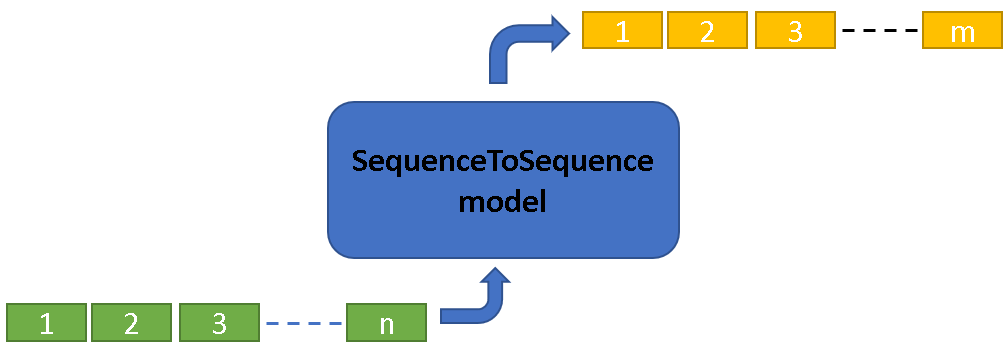
<center>Figure1: High level view of sequence translation</a></center>

`SeqenceToSequence` model in `arcgis.learn.text` module is built on top of [Hugginface transformers](https://huggingface.co/transformers/) library. This library provides access to a wide range of transformer architectures. 

The transformer architecture as proposed in the [Attention is all you need](https://arxiv.org/abs/1706.03762) paper, consists of an encoder block and a decoder block. Many of the latest transformer-based architectures like BERT, RoBERTa, ALBERT utilizes only the encoder part of the transformer. Whereas other models like GPT, GPT-2, etc. utilizes only the decoder part of the architecture. But, for SequenceToSequence  tasks we need both the encoder and decoder.  T5, Bart, MBart are few examples of such architectures, which preserve both the encoder and decoder.

For a detailed walkthrough of transformer architecture, refer to Jay Almmar's blogpost [[1]](#References).



# Prerequisites

* Refer to the section [Install deep learning dependencies of arcgis.learn module](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies) for detailed explanation about deep learning dependencies.
* Labeled data: For SequenceToSequence to learn, it needs to see examples that have been translated in a way that the model is expected to translate an input text into. Head to the Data preparation section to see the supported formats for training data.

# Data preparation

The `SequenceToSequence` class in `arcgis.learn.text` module can consume labeled training data in [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file format


Sample input data format for `SeqenceToSequence` model training:

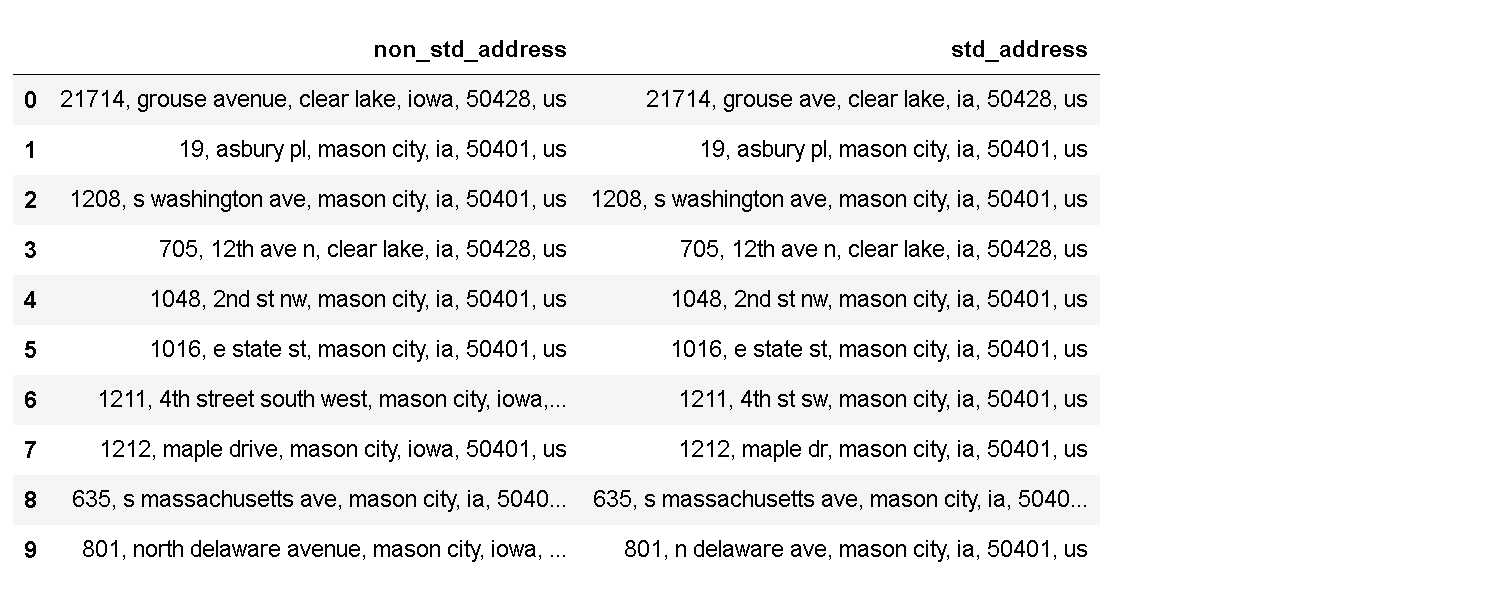

Training data must have two columns, one for input text and the other for translated output text. In the above example, `non_std_address` is the input text column, which has addresses from the U.S. in a non-standard format. `std_address` is the output text column which has the input address translated into a standard format.

**Data preparation** involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on. The `prepare_textdata` function can directly read the training samples in the above specified format and automate the entire process. While calling this function, the user has to provide the following arguments:
- **path**&nbsp;&ensp;&emsp;&emsp;&emsp;&emsp;- &emsp;&emsp;&emsp;&emsp;        The **full directory path** where the **training file** is present
- **task**&nbsp;&ensp;&emsp;&nbsp;&emsp;&emsp;&emsp;- &emsp;&emsp;&emsp;&emsp;       The **task** for which the **dataset** is being prepared, for `SequenceToSequence` model  
 &nbsp;&ensp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;pass **"sequence_translation"** as the task name.
- **train_file**&nbsp;&ensp;&emsp;&nbsp;&ensp;&nbsp;-  &emsp;&emsp;&emsp;&emsp; The file name containing the **training data**. Supported file format/extension is **.csv**
- **text_columns**&nbsp;&nbsp;-  &emsp;&emsp;&emsp;&emsp; The column name in the csv file that will be used as **input feature**.
- **label_columns** -  &emsp;&emsp;&emsp;&emsp;The column denoting the translated text.

Some pre-processing functions are also provided like removing [HTML tags](https://html.com/tags/) from the text or removing the [URLs](https://en.wikipedia.org/wiki/URL) from the text. Users can decide if these pre-processing steps are required for their dataset or not.

**A note on the dataset**
- The data is collected around 2020-04-30 by [OpenAddresses](http://openaddresses.io).
- The data licenses can be found in `data/address_standardization_correction_data/LICENSE.txt`.

In [1]:
from arcgis.learn import prepare_textdata
from arcgis.learn.text import SequenceToSequence

In [2]:
data = prepare_textdata(path='data/', batch_size=16, task='sequence_translation', 
                        text_columns='non_std_address', label_columns='std_address', 
                        train_file='address_standardization.csv')

`show_batch()` method can be used to visualize the training samples, along with labels.

In [3]:
data.show_batch()

non_std_address,std_address
"366, richland avenue, athens, ohio, 45701.0, us","366, richland ave, athens, oh, 45701.0, us"
"524, parnell drive, branson, missouri, 65616, us","524, parnell dr, branson, mo, 65616, us"
"26645.0, freedom valley dr, washburn, wi, 54891.0, us","26645.0, freedom valley dr, washburn, wi, 54891.0, us"
"15728.0, 430th avenue, delavan, minnesota, 56023.0, us","15728.0, 430th ave, delavan, mn, 56023.0, us"
"7129, tr 664, nan, ohio, 44624, us","7129, tr 664, nan, oh, 44624, us"


# SequenceToSequence model

The `SequenceToSequence` model training and inferencing workflows are similar to computer vision models in `arcgis.learn`.

## Model instantiation


SequenceToSequence class constructor accepts two named arguments `data`(required) and `backbone`(optional). 

`data`: `TextDataObject` object prepared with the `prepare_textdata()` function.

`backbone`: A pretrained transformer model based on the transformer architecture of choice.

## How to choose an appropriate backbone for your dataset?

`supported_backbones` attribute can be called on `SequenceToSequence` class to see the supported backbones (transformer architectures) by the model 

In [4]:
SequenceToSequence.supported_backbones

['T5', 'Bart', 'Marian']

`available_backbone_models()` method accepts one of the `supported_backbones` and returns a list (this list is not exhaustive) of pretrained models for that backbone/architecture.

Users can choose a supported backbone and a pretrained model based on the task the model is to be trained on. It is preferable to choose a model that was trained on a similar task and data.

For instance, if a user is training a model for summarizing English text. It would be most appropriate to choose `T5` architecture and `t5-base-finetuned-summarize-news` model, as this model was trained for summarization downstream task.

Visit [HuggingFace model zoo](https://huggingface.co/models) and filter the tags based on the task to find all the available pretrained models for that particular task.

In [5]:
SequenceToSequence.available_backbone_models('T5')

['t5-small',
 't5-base',
 't5-large',
 't5-3b',
 't5-11b',
 'See all T5 models at https://huggingface.co/models?filter=t5 ']

In [6]:
model = SequenceToSequence(data,backbone='t5-base')

## Model training

### Finding optimum learning rate

In machine learning, the `learning rate`[[2]](#References) is a tuning parameter that determines the step size at each iteration while moving toward a minimum of a loss function, it represents the speed at which a machine learning model "learns"

- If the **learning rate is low**, then model training will take a lot of time because steps towards the minimum of the loss function are tiny.
- If the **learning rate is high**, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.

We have to find an **optimum learning rate** for the dataset we wish to train our model on. To do so we will call the `lr_find()` method of the model.

**Note**

- A user is not required to call the `lr_find()` method separately. If `lr` argument is not provided while calling the `fit()` method then `lr_find()` method is internally called by the `fit()` method to find the optimal learning rate.

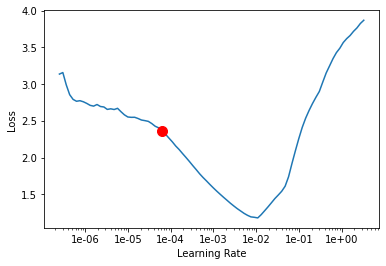

In [7]:
lr = model.lr_find()

Training the model is an iterative process. We can train the model using its `fit()` method till the validation loss (or error rate) continues to go down with each training pass also known as epoch. This is indicative of the model learning the task. 

In [8]:
model.fit(epochs=4, lr=lr)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,0.001017,0.001049,0.999739,0.999311,1:46:22
1,0.000797,0.000705,0.999817,0.999521,1:47:22
2,0.000314,0.000421,0.999896,0.999720,1:48:03
3,0.000213,0.000380,0.999916,0.999773,1:48:06


### Evaluate model performance

Call `get_model_metrics()` to calculate accuracy [[3]](#References) and bleu [[4]](#References) score on the validation data.


In [9]:
model.get_model_metrics()

{'seq2seq_acc': 0.9999, 'bleu': 0.9998}

BLEU : (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Refer to [this](https://www.aclweb.org/anthology/P02-1040.pdf) paper for details on BLEU score.

###  Validate results

Once we have the trained model, we can see the results to see how it performs.

In [10]:
model.show_results()

text,target,pred
"3001.0, ronald reagan cross colorado wb highway, sycamore township ham ohio, ohio, 45236.0, us","3001.0, ronald reagan cross co wb hwy, sycamore township ham oh, oh, 45236.0, us","3001.0, ronald reagan cross co wb hwy, sycamore township ham oh, oh, 45236.0, us"
"702.0, ronald reagan cross colorado wb highway, colerain township ham ohio, ohio, 45251.0, us","702.0, ronald reagan cross co wb hwy, colerain township ham oh, oh, 45251.0, us","702.0, ronald reagan cross co wb hwy, colerain township ham oh, oh, 45251.0, us"
"3208.0, ronald reagan cross co eb hwy, sycamore township ham oh, oh, 45242.0, us","3208.0, ronald reagan cross co eb hwy, sycamore township ham oh, oh, 45242.0, us","3208.0, ronald reagan cross co eb hwy, sycamore township ham oh, oh, 45242.0, us"
"3102.0, ronald reagan cross colorado eb highway, blue ash ham ohio, ohio, 45236.0, us","3102.0, ronald reagan cross co eb hwy, blue ash ham oh, oh, 45236.0, us","3102.0, ronald reagan cross co eb hwy, blue ash ham oh, oh, 45236.0, us"
"7679.0, ginnala connecticut, sycamore township ham ohio, ohio, 45243.0, us","7679.0, ginnala ct, sycamore township ham oh, oh, 45243.0, us","7679.0, ginnala ct, sycamore township ham oh, oh, 45243.0, us"


In [11]:
model.save('add_standardization_4E_bleu_99')

Computing model metrics...


PosixPath('models/add_standardization_4E_bleu_99')

# Model inference

The trained model can be used to translate new text documents using the `predict()` method. This method accepts a string or a list of strings to translate new documents/text.

In [12]:
txt=['12160, eagle scout connecticut, sycamore township ham ohio, ohio, 45249, us',
     '2808, ronald reagan cross colorado wb highway, reading ham ohio, ohio, 45215, us']

In [13]:
model.predict(txt, max_length=50)

[('12160, eagle scout connecticut, sycamore township ham ohio, ohio, 45249, us',
  '12160, eagle scout ct, sycamore township ham oh, oh, 45249, us'),
 ('2808, ronald reagan cross colorado wb highway, reading ham ohio, ohio, 45215, us',
  '2808, ronald reagan cross co wb hwy, reading ham oh, oh, 45215, us')]

# References

[1] [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)

[2] [Learning Rate](https://en.wikipedia.org/wiki/Learning_rate)

[3] [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)

[4] [Bleu score](https://en.wikipedia.org/wiki/BLEU)